# DTW Evaluation

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import ast
import fastdtw
from scipy.spatial.distance import euclidean
from itertools import combinations
from lyrics_stats import lyrics_statistics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## DTW: The idea behind

In [2]:
def generate_uni_features_ts(lyrics):
    multi_ts = pd.DataFrame(lyrics_statistics(lyrics)).values
    ss = StandardScaler()
    multi_ts = ss.fit_transform(multi_ts)
    pca = PCA(n_components=1, random_state=0)
    uni_ts = np.array([pc[0] for pc in pca.fit_transform(multi_ts)])
    return uni_ts

In [3]:
eg_lyr = pd.read_csv('../data/toy-lyrics/toy_lyr.csv', sep='\t')
eg_similar_lyr = pd.read_csv('../data/toy-lyrics/toy_sim.csv', sep='\t')
eg_random_lyr = pd.read_csv('../data/toy-lyrics/toy_rnd.csv', sep='\t')

eg_lyrics = [eg_lyr, eg_similar_lyr, eg_random_lyr]

In [9]:
ts1, ts2, ts3 = [generate_uni_features_ts(list(lyr['lyrics'])) for lyr in eg_lyrics]

ts1_parts, ts2_parts, ts3_parts = [lyr['part'] for lyr in eg_lyrics]

color_map = {}
for idx, part_of_lyrics in enumerate(list(dict.fromkeys(ts1_parts))):    
    # Map color excluding first color of the palette 
    color_map[part_of_lyrics] = sns.color_palette()[idx+1]

In [10]:
sim_distance, warp_path = fastdtw.dtw(ts1, ts2)
print(f'DTW distance between similar lyrics: {sim_distance}')

rnd_distance = fastdtw.dtw(ts1, ts3)[0]
print(f'DTW distance between random lyrics: {rnd_distance}')

DTW distance between similar lyrics: 24.269195973072804
DTW distance between random lyrics: 37.68821150493047


In [11]:
ts2 = [10 + timestamp for timestamp in ts2] 

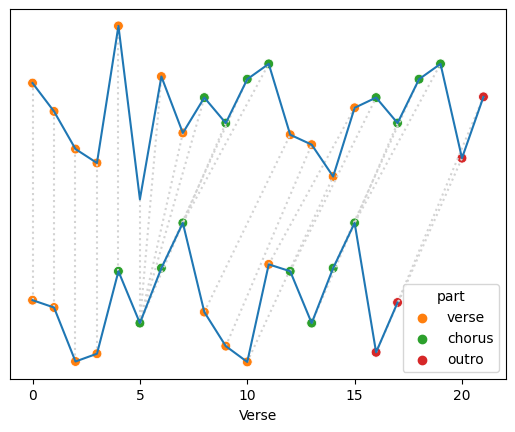

In [15]:
fig, ax = plt.subplots()

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [ts1[map_x], ts2[map_y]], linestyle='dotted', color='lightgray')

sns.lineplot(ts1, color=sns.color_palette()[0]) 
sns.lineplot(ts2, color=sns.color_palette()[0])

sns.scatterplot(y=ts1, x=range(len(ts1)),
                hue=ts1_parts, s=50, palette=color_map)

sns.scatterplot(y=ts2, x=range(len(ts2)),
                hue=ts2_parts, s=50, palette=color_map, legend=False)


ax.set_yticklabels([])
ax.set_ylabel('')
ax.set_xlabel('Verse')
ax.tick_params(left=False)  # remove the ticks
plt.show()

In [ ]:
def plot_evaluation_data(ts_types):
    dtw_distances = {}
    for ts_type in tqdm(ts_types):
        ts_data = pd.read_csv(f'../data/evaluation/time-series/{ts_type}.csv')
        for column in ts_data.columns:
            ts_data[column] = list(map(lambda x: ast.literal_eval(x), ts_data[column]))
        sim_dtw = [fastdtw.dtw(ts1, ts2)[0] for ts1, ts2 in zip(ts_data['lyrics'], ts_data['similar_lyrics'])]
        rnd_dtw = [fastdtw.dtw(ts1, ts2)[0] for ts1, ts2 in zip(ts_data['lyrics'], ts_data['random_lyrics'])]
        sim_nearest_rate = sum(1 for similar, random in zip(sim_dtw, rnd_dtw) if similar < random)/len(sim_dtw)        
        dtw_data = pd.DataFrame({'similar': sim_dtw, 'random':rnd_dtw})
        dtw_distances[ts_type] = dtw_data
        print(ts_type)
        print()
        print(f'Similar ts closer than random ts: {round(sim_nearest_rate, 2)}')
    
    fig, axs = plt.subplots(1,len(dtw_distances), sharey=True, figsize=(18,5))
    fig.suptitle('Time series pairs by dtw distance')
    for count, ts_type in enumerate(dtw_distances):
        sns.histplot(dtw_distances[ts_type], kde=True, ax=axs[count]) 
        axs[count].set_title(ts_type)
        axs[count].set_xlabel('dtw distance')
    plt.show()

## Sentence BERT Time Series

 33%|███▎      | 1/3 [00:02<00:05,  2.68s/it]

sbert_avg_ts

Similar ts closer than random ts: 0.78


 67%|██████▋   | 2/3 [00:05<00:02,  2.57s/it]

sbert_max_ts

Similar ts closer than random ts: 0.77


100%|██████████| 3/3 [00:07<00:00,  2.56s/it]

sbert_pca_ts

Similar ts closer than random ts: 0.77


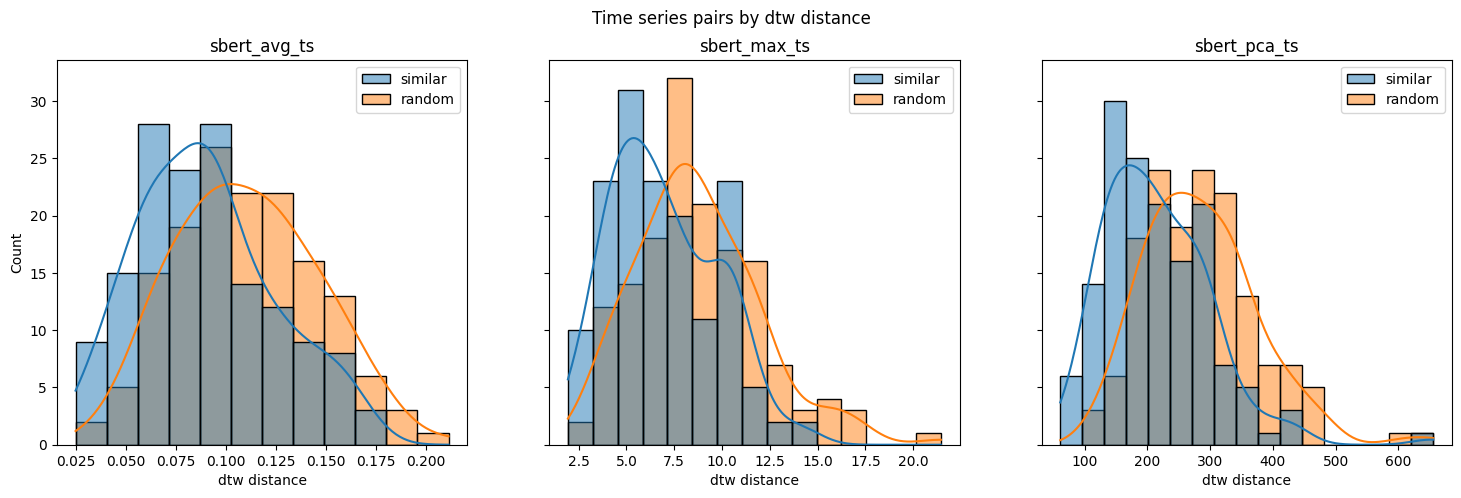

In [26]:
ts_types = ['sbert_avg_ts', 'sbert_max_ts', 'sbert_pca_ts']

plot_evaluation_data(ts_types)

## Doc2Vec Time Series

 25%|██▌       | 1/4 [00:02<00:07,  2.47s/it]

d2v_avg_ts

Similar ts closer than random ts: 0.41


 50%|█████     | 2/4 [00:05<00:05,  2.55s/it]

d2v_max_ts

Similar ts closer than random ts: 0.58


 75%|███████▌  | 3/4 [00:07<00:02,  2.51s/it]

d2v_pca_ts

Similar ts closer than random ts: 0.67


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]

d2v_ts

Similar ts closer than random ts: 0.58


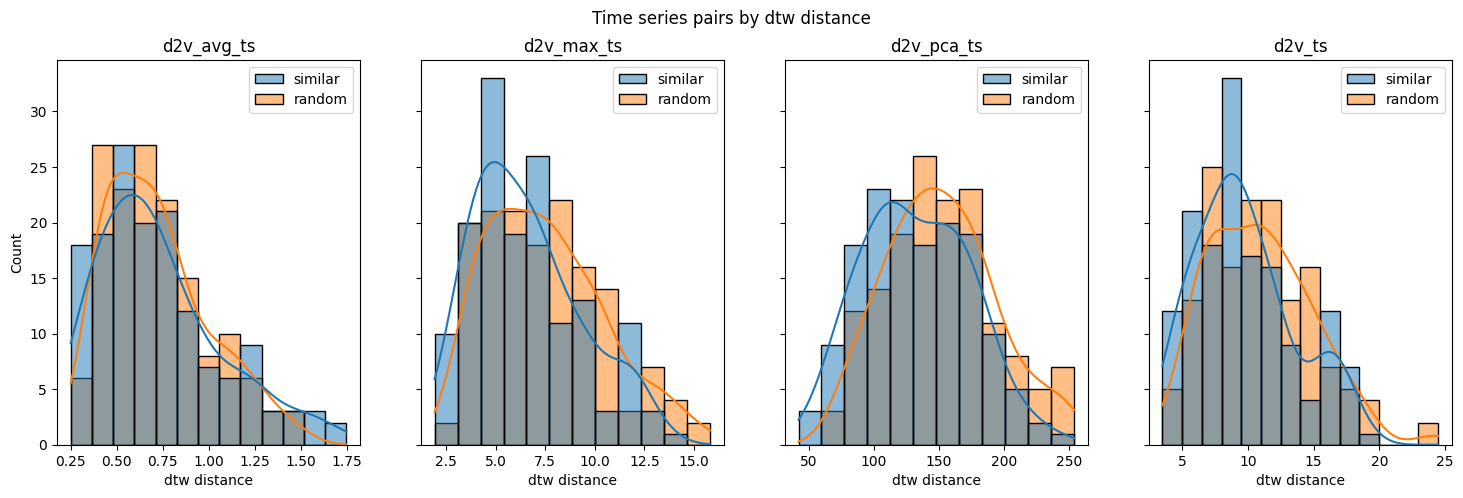

In [27]:
ts_types = ['d2v_avg_ts', 'd2v_max_ts', 'd2v_pca_ts', 'd2v_ts']

plot_evaluation_data(ts_types)

## Emotion Time Series

 50%|█████     | 1/2 [00:02<00:02,  2.90s/it]

emotion_pca_ts

Similar ts closer than random ts: 0.76


100%|██████████| 2/2 [00:05<00:00,  2.76s/it]

sentiment_ts

Similar ts closer than random ts: 0.83


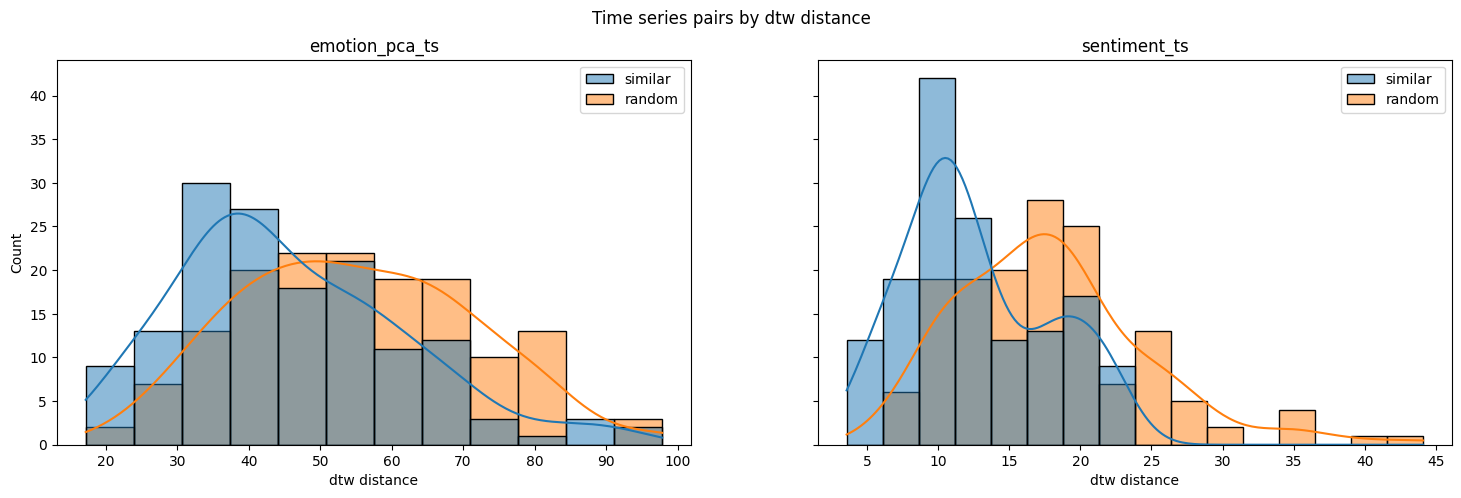

In [28]:
ts_types = ['emotion_pca_ts', 'sentiment_ts']

plot_evaluation_data(ts_types)

## Features Time Series

 33%|███▎      | 1/3 [00:02<00:05,  2.93s/it]

features_avg_ts

Similar ts closer than random ts: 0.86


 67%|██████▋   | 2/3 [00:05<00:02,  2.75s/it]

features_max_ts

Similar ts closer than random ts: 0.69


100%|██████████| 3/3 [00:08<00:00,  2.71s/it]

features_pca_ts

Similar ts closer than random ts: 0.79


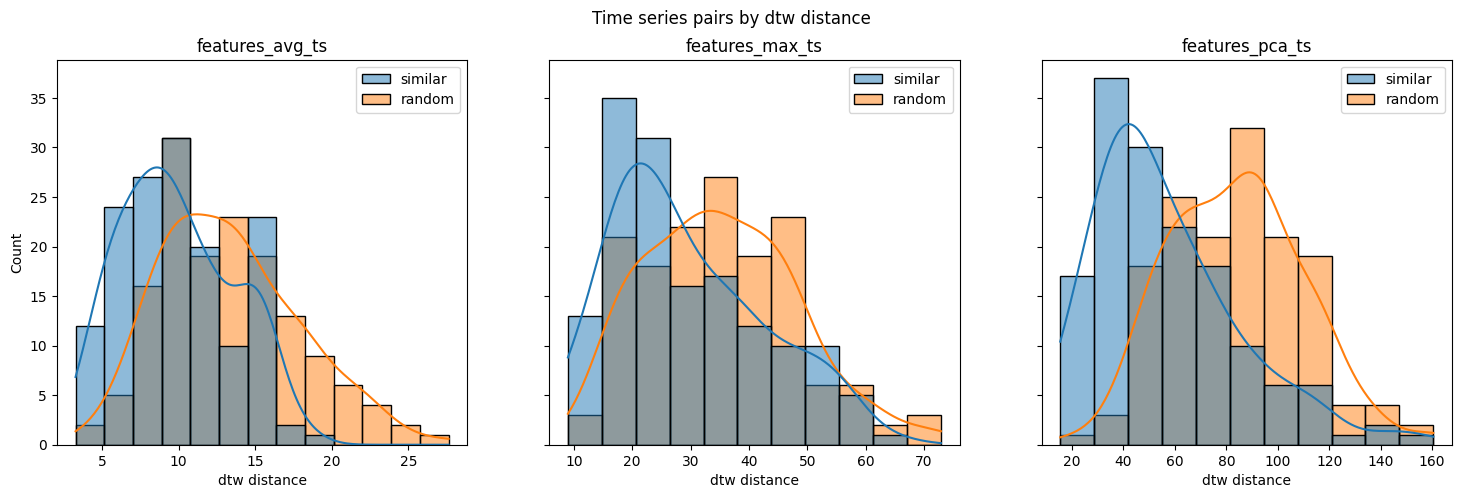

In [29]:
ts_types = ['features_avg_ts', 'features_max_ts', 'features_pca_ts']

plot_evaluation_data(ts_types)